# Data Prepration



In this tutorial, we mainly work with the data collected from "parenting" and "feminisim" forums from Mumsnet and Reddit platforms.  




### How to get the data from Reddit?


1) Reddit API wrapper, such as PRAW

2) GoogleBigQuery 

For how to use these apptoaches to get the data from Reddit, check the ./extra/GoogleBigQuery.txt and ./extra/RedditCrawler.ipynb

### How to get the data from Mumsnet?
Mumsnet is not a public website, so, in order to collect its data you need their permision. And then you can write a crawler to collect the data. 

<br>
<br>
<br>

We need to take a few steps to convert the raw data (forum text data) to the one that we can use for our salient social identity detection model (LIWC feature vectors):

1- Cleaning

2- Preparing the data for extracting the LIWC categorise

3- Processing for LIWC features



<br>
<br>

First, read the data from CSV file:

In [1]:
#1

# path to the csv files
path = './preprocessing/sample_raw_data/'
file_name = 'sample'

import pandas as pd

# reading reddit file
sample = pd.read_csv(path + file_name + '.csv')

print(list(sample))
print(sample.shape)

['id', 'author', 'body']
(13, 3)


In [2]:
#2

sample

,id,author,body
0,1,author1,"So we beat on, boats against the current, born..."
1,2,author1,He turned out the light and went into Jem's ro...
2,3,author1,The eyes and faces all turned themselves towar...
3,4,author2,"The creatures outside looked from pig to man, ..."
4,5,author2,Very few castaways can claim to have survived ...
5,6,author2,"But wherever they go, and whatever happens to ..."
6,7,author2,"Whatever our struggles and triumphs, however w..."
7,8,author2,Message deleted
8,9,author3,Message withdrawn at poster's request.
9,10,[deleted],"In the meantime, she would just live."


### Data Cleaning

These are the steps I used to preprocesses raw csv files to remove copy artifacts, and prepare them for importing into the database. These steps are particularly relevant to the Mumsnet dataset and Reddit dataset, but they may be helpful for data collected from other platforms too.

###### Dropping unwanted posts

Sometimes a post is deleted by the moderator of forum or by user herself. 


In case of mumsnet, these posts could be detected by matching with patterns such as "Message deleted", 
"Message deleted by Mumsnet", "Message withdrawn", "Message withdrawn at poster's request". For reddit data, there are patterns like "[deleted]", "[removed]", "[deleted by user]". 
We also drop the posts which belong to users who are no longer in the platform, by matching with patterns like
"[deleted]", and "[removed]". 

There are also some posts generated with bots and contains patterns like  "I'm a bot...", . This is particularly relevant to reddit data but it may be helpful for other data too.



For this, we design some regular experessions to capture these patterns inside text and then drop them from our data:




In [3]:
#3

#regelar expressions to find the matched patterns
regex_1 = "message deleted"
regex_2 = "message withdrawn at poster's request."

regex_3 = '\[deleted\]'
regex_4 = '\[removed\]'

In [4]:
#4

import re
nan_value = float("NaN")
    
def cleaning(text, regex):
    proctext = str(text).lower()
    if not (re.search(regex, proctext) is None):
        return nan_value
    else:
        return proctext
    

Here we would apply one of the regular expression on our data:

In [5]:
#5

sample['body'] = sample['body'].apply(lambda x: cleaning(x, regex_1))
sample

,id,author,body
0,1,author1,"so we beat on, boats against the current, born..."
1,2,author1,he turned out the light and went into jem's ro...
2,3,author1,the eyes and faces all turned themselves towar...
3,4,author2,"the creatures outside looked from pig to man, ..."
4,5,author2,very few castaways can claim to have survived ...
5,6,author2,"but wherever they go, and whatever happens to ..."
6,7,author2,"whatever our struggles and triumphs, however w..."
7,8,author2,NaN
8,9,author3,message withdrawn at poster's request.
9,10,[deleted],"in the meantime, she would just live."


Now, we get rid of the rows with NaN values.

In [6]:
#6

sample.dropna(subset=['body'], inplace=True)
sample

,id,author,body
0,1,author1,"so we beat on, boats against the current, born..."
1,2,author1,he turned out the light and went into jem's ro...
2,3,author1,the eyes and faces all turned themselves towar...
3,4,author2,"the creatures outside looked from pig to man, ..."
4,5,author2,very few castaways can claim to have survived ...
5,6,author2,"but wherever they go, and whatever happens to ..."
6,7,author2,"whatever our struggles and triumphs, however w..."
8,9,author3,message withdrawn at poster's request.
9,10,[deleted],"in the meantime, she would just live."
10,11,[removed],he loved big brother.


And now we apply all the regular expressions we desinged on our data to clean all the unwanted posts:

In [7]:
#7

sample['body'] = sample['body'].apply(lambda x: cleaning(x, regex_2))
sample.dropna(subset=['body'], inplace=True)
sample['author'] = sample['author'].apply(lambda x: cleaning(x, regex_3))
sample.dropna(subset=['author'], inplace=True)
sample['author'] = sample['author'].apply(lambda x: cleaning(x, regex_4))
sample.dropna(subset=['author'], inplace=True)

sample

,id,author,body
0,1,author1,"so we beat on, boats against the current, born..."
1,2,author1,he turned out the light and went into jem's ro...
2,3,author1,the eyes and faces all turned themselves towar...
3,4,author2,"the creatures outside looked from pig to man, ..."
4,5,author2,very few castaways can claim to have survived ...
5,6,author2,"but wherever they go, and whatever happens to ..."
6,7,author2,"whatever our struggles and triumphs, however w..."
11,12,author4,fill out this 5 minute survey -- chance to rec...
12,13,author4,research study- parents needed


###### small practice

By carefully reading the remaining posts, we see the last two ones are advertisement and are not actually content posted by the parents. As we mentioned before, according to the objective of your study you might do some extra cleaning. 

Now you are asked to follow the same steps as above, to identify these rows, first, by designing proper regular expression, next, dropping them from the dataframe.

In [8]:
# write your code here



,id,author,body
0,1,author1,"so we beat on, boats against the current, born..."
1,2,author1,he turned out the light and went into jem's ro...
2,3,author1,the eyes and faces all turned themselves towar...
3,4,author2,"the creatures outside looked from pig to man, ..."
4,5,author2,very few castaways can claim to have survived ...
5,6,author2,"but wherever they go, and whatever happens to ..."
6,7,author2,"whatever our struggles and triumphs, however w..."


In [9]:
#8

# saving the cleaned data file
sample.to_csv(path + file_name + '_cleaned.csv', index=False)

## Preparing the data for extracting the LIWC categorise

In case you are dealing with large dataset (like in our case), we suggest you to save your dataset into a database tables. Having our data in format of a table gives us the following advantagous:

- visualization (having access to different parts our data)
- managable (updating our dataset)
- searchable (searching for a specific user or post by mysql commands)

You can follow the instructions in our other tutroal https://github.com/Identity-lab/Tutorial-on-salient-social-Identity-detection-model/blob/master/Tutorial_data_prepration.ipynb for this (because of time limitation we won't go through that in this tutorial).



Next step is to prepare our data in a format compatible with the LWIC software. We do some extra cleaning by mainly dropping the new lines, several spaces, ...



In [10]:
#9

import sys
import re


def cleaning_for_LIWC(text, lowercase=True):
    WHITESPACEREGEX = r'[ \t\n\r\f\v]+'
    NONPUNCREGEX = r'[a-zA-Z0-9_\s]'
    
    if lowercase:
        proctext = text.lower()
    else:
        proctext = text
            
    proctext = proctext.strip()
    
    # now replace newlines with space 
    proctext.replace('\n',' ')

    
    # remove all duplicate whitespace
    proctext = re.sub(WHITESPACEREGEX, ' ', proctext)
    
    # if text is only punctuation, remove it
    if re.search(NONPUNCREGEX, proctext) is None:
        proctext = ''
        
    return proctext



def write_single_file(df, 
                      txtfpath, idfpath,  
                      lowercase=True, parasep='\n\n\n',
                      dummytext='xxxdummyxxx'):

    with open(txtfpath, 'w') as of_handler, open(idfpath, 'w') as idf_handler:
        # iterate through and write each to file
        # cursor.execute(selectquery)
        count = 0
        for i, row in df.iterrows():
            id = row['id']
            text = row['body']

            # if the text does not contain any words then skip it
            if re.search('[a-zA-Z]', text) is None:
                continue

            text = cleaning_for_LIWC(text,lowercase)

            if len(text) == 0:
                continue

            # insert paragraph separator if line is greater than 0
            if count > 0:
                of_handler.write(parasep)
                
            text = str(text)
                
            # adding a dummy word at the enf of each post
            # without it, the liwc results might be inconsistant with the data
            of_handler.write(text + ' ' + dummytext)  
            

            idf_handler.write(str(id) + '\n')
            count += 1
            if (i % 10000) == 0:
                sys.stdout.flush()
                
    if not test_numlines_txt_vs_ids(txtfpath, idfpath):
                raise ValueError('File lines do not match')
                

def test_numlines_txt_vs_ids(txtfpath, idfpath):
    numlines_txt = sum(1 for line in open(txtfpath))
    numlines_ids = sum(1 for line in open(idfpath))

    lengths_match = ((numlines_ids * 3) - 2) == numlines_txt


    if lengths_match:
        print('File lengths are consistent, with %d items' % (numlines_ids,))
        return True
    else:
        print('File lengths are inconsistent')
        print('numlines: txt=%d, ids=%d' % (numlines_txt, numlines_ids))
        return False

In [11]:
#10

filename = 'minimal'
txtfpath = path + filename + '.txt'
idfpath = path + filename + '.ids'

write_single_file(sample,txtfpath, idfpath)

File lengths are consistent, with 7 items


## Processing for LIWC features

Now the data is ready to be imported to LIWC software. This requires a copy of the LIWC software, and a copy of LIWC dictionary (we used LIWC_2007 dictionary). 

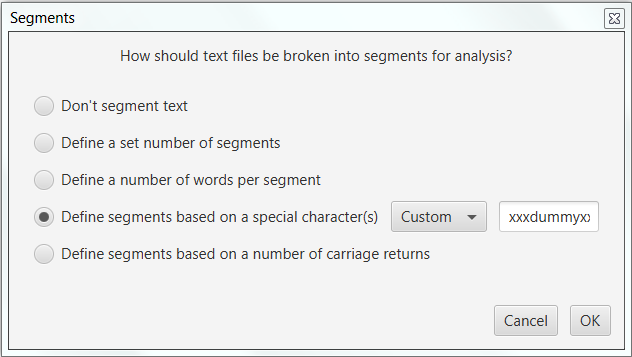


Next step is to feed our text file into LIWC and extract the categories. Save the results in the same folder as the text and ids files (for example with name such as liwc_sample.csv).

In [12]:
#11

liwcsample = pd.read_csv(path+'liwc_sample.csv')
list(liwcsample)

['Filename',
 'Segment',
 'WC',
 'WPS',
 'Sixltr',
 'Dic',
 'funct',
 'pronoun',
 'ppron',
 'i',
 'we',
 'you',
 'shehe',
 'they',
 'ipron',
 'article',
 'verb',
 'auxverb',
 'past',
 'present',
 'future',
 'adverb',
 'preps',
 'conj',
 'negate',
 'quant',
 'number',
 'swear',
 'social',
 'family',
 'friend',
 'humans',
 'affect',
 'posemo',
 'negemo',
 'anx',
 'anger',
 'sad',
 'cogmech',
 'insight',
 'cause',
 'discrep',
 'tentat',
 'certain',
 'inhib',
 'incl',
 'excl',
 'percept',
 'see',
 'hear',
 'feel',
 'bio',
 'body',
 'health',
 'sexual',
 'ingest',
 'relativ',
 'motion',
 'space',
 'time',
 'work',
 'achieve',
 'leisure',
 'home',
 'money',
 'relig',
 'death',
 'assent',
 'nonfl',
 'filler',
 'AllPunc',
 'Period',
 'Comma',
 'Colon',
 'SemiC',
 'QMark',
 'Exclam',
 'Dash',
 'Quote',
 'Apostro',
 'Parenth',
 'OtherP']

In [13]:
#12

liwcsample = liwcsample.drop(['Filename', 'Segment'], axis=1)

In [14]:
#13

idsfile = open(path+"minimal.ids","r")
ids = idsfile.readlines()
ids = [int(id.replace('\n', '')) for id in ids]
liwcsample['id'] = ids

liwcsample

,WC,WPS,Sixltr,Dic,funct,pronoun,ppron,i,we,you,...,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP,id
0,15,15.0,26.67,80.00,53.33,6.67,6.67,0,6.67,0,...,0,0.00,0,0,0,0,0.00,0,0,1
1,29,14.5,6.90,86.21,65.52,10.34,10.34,0,0.00,0,...,0,0.00,0,0,0,0,3.45,0,0,2
2,25,25.0,24.00,84.00,64.00,20.00,20.00,12,0.00,0,...,0,0.00,0,0,0,0,0.00,0,0,3
3,30,15.0,16.67,83.33,60.00,10.00,0.00,0,0.00,0,...,0,3.33,0,0,0,0,0.00,0,0,4
4,26,13.0,15.38,69.23,53.85,0.00,0.00,0,0.00,0,...,0,0.00,0,0,0,0,0.00,0,0,5
5,33,16.5,18.18,87.88,57.58,15.15,9.09,0,0.00,0,...,0,0.00,0,0,0,0,0.00,0,0,6
6,25,12.5,20.00,88.00,60.00,20.00,16.00,0,8.00,0,...,0,0.00,0,0,0,0,0.00,0,0,7
